we will proceed to install all the necessary libraries:

In [ ]:
!pip install -qqq transformers==4.27.2 --progress-bar off

In [ ]:
!pip install -qqq pytorch-lightning==1.9.4 --progress-bar off

In [ ]:
!pip install -qqq torchmetrics==0.11.4 --progress-bar off

In [ ]:
!pip install -qqq imgkit==1.2.3 --progress-bar off

In [ ]:
!pip install -qqq easyocr==1.6.2 --progress-bar off

In [ ]:
!pip install -qqq Pillow==9.5.0 --progress-bar off
# !pip install --upgrade Pillow

In [ ]:
!pip install -qqq tensorboardX==2.5.1 --progress-bar off

In [ ]:
!pip install -qqq huggingface_hub==0.11.1 --progress-bar off

In [ ]:
!pip install -qqq --upgrade --no-cache-dir gdown

In [ ]:
!pip install pdf2image

In [ ]:
!apt-get install poppler-utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Add all imports that we'll use

In [ ]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shutil
import glob
import imgkit
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pdf2image import convert_from_path

%matplotlib inline
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

convert PDF files to images

In [ ]:
# Define a function to convert pdf files to images
def convert_pdf_folder_to_images(input_folder, output_folder):
    # Get the list of PDF files in the input folder
    pdf_files = [f for f in os.listdir(input_folder) if f.endswith(".pdf")]

    # Loop over each PDF file and convert it to images
    for pdf_file in pdf_files:
        pdf_path = os.path.join(input_folder, pdf_file)
        images = convert_from_path(pdf_path)
        os.makedirs(output_folder+'/'+pdf_file.split(".")[0], exist_ok=True)
        # Save each page of the PDF file as a separate image
        for i, image in enumerate(images):
            image_path = os.path.join(output_folder+'/'+pdf_file.split(".")[0], f"{pdf_file.replace('.pdf', '')}_{i+1}.jpg") # Change this based on the name of pdf files
            image.save(image_path, "JPEG")


In [ ]:
# Define input and output folders as the arguments of the created 'convert_pdf_folder_to_images function
pdf_path = '/content/drive/MyDrive/new_nursing_docs/'
output_dir = '/content/drive/MyDrive/converted_images'

In [ ]:
# Convert pdf files to images
convert_pdf_folder_to_images(pdf_path, output_dir)

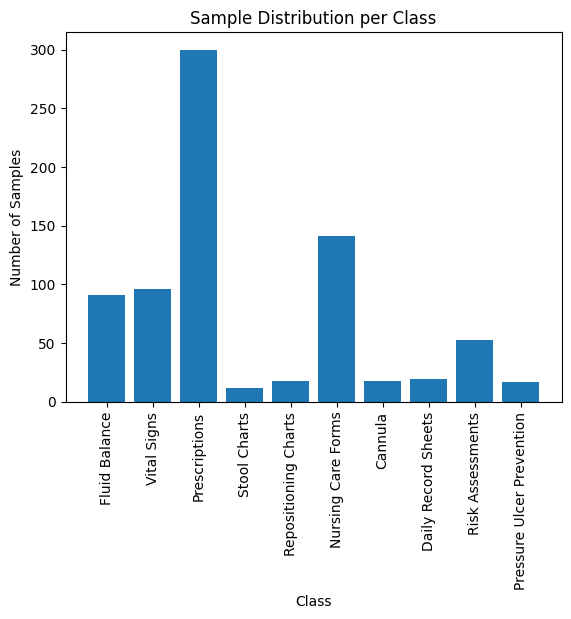

In [ ]:
import matplotlib.pyplot as plt
import os

# Get the list of class folders
class_folders = os.listdir(output_dir)

# Initialize empty lists to store class names and sample counts
class_names = []
sample_counts = []

# Iterate over each class folder
for class_folder in class_folders:
    class_dir = os.path.join(output_dir, class_folder)

    # Count the number of image files in the class folder
    num_samples = len([file for file in os.listdir(class_dir) if file.endswith(".jpg")])

    # Append the class name and sample count to the lists
    class_names.append(class_folder)
    sample_counts.append(num_samples)

# Plot the bar chart
plt.bar(class_names, sample_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Sample Distribution per Class")
plt.xticks(rotation=90)

# Display the chart
plt.show()


# EasyOCR
EasyOCR is a Python library for optical character recognition (OCR), which is the process of extracting text from images. EasyOCR uses deep learning models to recognize text and can handle a wide range of font styles, sizes, and orientations.

In [ ]:
# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# Feed a sample image into the EasyOCR reader
image_path = '/content/drive/MyDrive/converted_images/Cannula/Cannula_10.jpg'

ocr_result = reader.readtext(str(image_path))
ocr_result[0]

In [ ]:
# Define a function to create bounding boxes based on the text box coordinates
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)

    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return [left, top, right, bottom]

# def create_bounding_box(bbox_data):
#     left, top, right, bottom = bbox_data
#     return [left, top, right, bottom]


In [ ]:
# Iterate over each image, and pass it to the EasyOCR reader to obtain the OCR results
for folder in Path(output_dir).glob("*"):
  for image_path in tqdm(Path(folder).glob("*.jpg")):
    image = Image.open(image_path).convert("RGB")
    ocr_result = reader.readtext(np.array(image))

    ocr_page = []
    for bbox, word, confidence in ocr_result:
        ocr_page.append({
            "word": word,
            "bounding_box": create_bounding_box(bbox)
        })

    # Save the OCR results as JSON files using the same filename as the images
    json_path = image_path.with_suffix(".json")
    with json_path.open("w") as f:
        json.dump(ocr_page, f)


91it [03:12,  2.11s/it]
96it [06:15,  3.91s/it]
300it [14:34,  2.91s/it]
12it [00:25,  2.10s/it]
18it [01:02,  3.45s/it]
141it [06:16,  2.67s/it]
18it [01:05,  3.64s/it]
19it [00:57,  3.05s/it]
53it [02:44,  3.10s/it]
17it [01:01,  3.61s/it]


Examine the OCR output overlaid on top of the document image

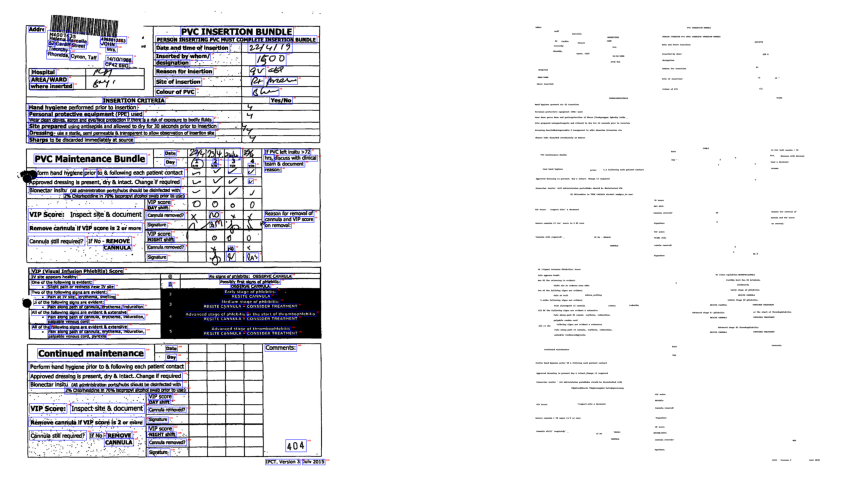

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import json

# Replace 'image_path' with the path to your chosen image
image_path = '/content/drive/MyDrive/converted_images/Cannula/Cannula_10.jpg'
json_path = '/content/drive/MyDrive/converted_images/Cannula/Cannula_10.json'

# Load the image
left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))

# Load the JSON file
with open(json_path, 'r') as f:
    ocr_result = json.load(f)

# Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))

left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)

# Iterate over OCR results and draw bounding boxes
for i, (row) in enumerate(ocr_result):
    bbox = row['bounding_box']
    word = row['word']

    box = create_bousnding_box(bbox)

    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box

    left_draw.text((right + 5, top), text=str(i + 1), fill="red")
    right_draw.text((left, top), text=word, fill="black")

# Show the images
ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off")
ax2.axis("off")

plt.show()

# LayoutLMv3
## Preprocessing

In [ ]:
# Create the feature extractor, tokenizer, and processor
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
def scale_bounding_box(box: List[int], width_scale: float = 1.0, height_scale: float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]

In [ ]:
# Iterate over the images in the folder
for folder in Path(output_dir).glob("*"):

  for image_file in os.listdir(folder):
      # Check if the file is an image file
      if image_file.endswith('.jpg') or image_file.endswith('.png'):
          # Get the image path
          image_path = os.path.join(folder, image_file)

          # Load the image
          image = Image.open(image_path).convert("RGB")
          width, height = image.size

          # Calculate the width and height scale
          width_scale = 1000 / width
          height_scale = 1000 / height

          # Load the OCR results from the JSON file
          json_path = Path(image_path).with_suffix(".json")
          with open(json_path, 'r') as f:
              ocr_result = json.load(f)

          # Extract words and bounding boxes
          words = []
          boxes = []
          for row in ocr_result:
              boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
              words.append(row["word"])

          # Encode the image, words, and boxes
          encoding = processor(
              image,
              words,
              boxes=boxes,
              max_length=512,
              padding="max_length",
              truncation=True,
              return_tensors="pt"
          )

          # Convert the image tensor to PIL image
          image_data = encoding["pixel_values"][0]
          transform = T.ToPILImage()
          transformed_image = transform(image_data)
          transformed_image.show()

In [ ]:
width, height = image.size
print(width)
print(height)

1682
2366


In [ ]:
len(words), len(boxes)

(128, 128)

In [ ]:
# Print the encoding information
print(f"""
input_ids:  {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
image data: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
""")


input_ids:  [512]
word boxes: [512, 4]
image data: [3, 224, 224]
image size: (1670, 2330)



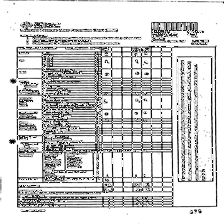

In [ ]:
image_data = encoding["pixel_values"][0]
transform = T.ToPILImage()
transform(image_data)

# Traning the model

In [ ]:
def scale_and_clip_bounding_box(bbox, width, height):
    # Scale bounding box coordinates based on image size
    scaled_bbox = bbox.clone()
    scaled_bbox[:, :, 0] *= width
    scaled_bbox[:, :, 1] *= height
    scaled_bbox[:, :, 2] *= width
    scaled_bbox[:, :, 3] *= height

    # Clip bounding box coordinates to the range of 0 to 1000
    scaled_bbox.clamp_(min=0, max=1000)

    return scaled_bbox


In [ ]:
model = LayoutLMv3ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv3-base", num_labels=10) # Change the number of labels (num_labels) based on the new dataset

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Extract the document classes
DOCUMENT_CLASSES = sorted(list(map(lambda p: p.name, Path(output_dir).glob("*"))))

print(DOCUMENT_CLASSES)

['Cannula', 'Daily Record Sheets', 'Fluid Balance', 'Nursing Care Forms', 'Prescriptions', 'Pressure Ulcer Prevention', 'Repositioning Charts', 'Risk Assessments', 'Stool Charts', 'Vital Signs']


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import uuid
#### Split the data into train and test
# Get the list of class folders
class_folders = os.listdir(output_dir)

# Initialize empty lists to store train and test file paths
train_files = []
test_files = []

# Create an empty list to store the labels
labels = []

# Iterate over each class folder
for class_folder in class_folders:
    class_dir = os.path.join(output_dir, class_folder)

    # Get the list of image and JSON file paths in the class folder
    image_files = [file for file in os.listdir(class_dir) if file.endswith(".jpg")]
    json_files = [file for file in os.listdir(class_dir) if file.endswith(".json")]

    # Split the image and JSON file paths into train and test sets
    train_images, test_images, train_json, test_json = train_test_split(image_files, json_files, test_size=0.2)

    # Move the train files to the train folder
    for train_image, train_json_file in zip(train_images, train_json):
        train_image_path = os.path.join(class_dir, train_image)
        train_json_path = os.path.join(class_dir, train_json_file)
        train_files.append((train_image_path, train_json_path))
        labels.append(class_folder)  # Append the class folder name as the label

    # Move the test files to the test folder
    for test_image, test_json_file in zip(test_images, test_json):
        test_image_path = os.path.join(class_dir, test_image)
        test_json_path = os.path.join(class_dir, test_json_file)
        test_files.append((test_image_path, test_json_path))

# Apply oversampling to the training data
ros = RandomOverSampler(random_state=42)
train_files, labels = ros.fit_resample(train_files, labels)

# Print the number os train and test set after oversampling
print(len(train_files))
print(len(test_files))

2400
158


In [ ]:
# Create the train and test directories
train_dir = '/content/drive/MyDrive/new_train_files'  # Change the directory
test_dir = '/content/drive/MyDrive/new_test_files'  # Change the directory

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move the train files to the train directory
for i, (train_image_path, train_json_path) in enumerate(train_files):
    class_folder = os.path.basename(os.path.dirname(train_image_path))
    unique_identifier = str(uuid.uuid4())  # Generate a unique identifier for each file
    target_image_path = os.path.join(train_dir, class_folder, f"{unique_identifier}.jpg")
    target_json_path = os.path.join(train_dir, class_folder, f"{unique_identifier}.json")
    os.makedirs(os.path.dirname(target_image_path), exist_ok=True)
    os.makedirs(os.path.dirname(target_json_path), exist_ok=True)
    shutil.copy(train_image_path, target_image_path)
    shutil.copy(train_json_path, target_json_path)

# Move the test files to the test directory
for test_image_path, test_json_path in test_files:
    class_folder = os.path.basename(os.path.dirname(test_image_path))
    target_image_path = os.path.join(test_dir, class_folder, os.path.basename(test_image_path))
    target_json_path = os.path.join(test_dir, class_folder, os.path.basename(test_json_path))
    os.makedirs(os.path.dirname(target_image_path), exist_ok=True)
    os.makedirs(os.path.dirname(target_json_path), exist_ok=True)
    shutil.copy(test_image_path, target_image_path)
    shutil.copy(test_json_path, target_json_path)

In [ ]:
import random
from torchvision.transforms import functional as F
import math

def apply_rotation(image, json_data, rotation_angle):
    # Apply rotation to the image
    rotated_image = F.rotate(image, rotation_angle)

    # Update the bounding box coordinates in the JSON file
    for bbox_data in json_data:
        bbox = bbox_data["bounding_box"]
        # Rotate the bounding box coordinates
        rotated_bbox = [
            rotate_point(bbox[0], bbox[1], rotation_angle, rotated_image.width, rotated_image.height),
            rotate_point(bbox[2], bbox[1], rotation_angle, rotated_image.width, rotated_image.height),
            rotate_point(bbox[2], bbox[3], rotation_angle, rotated_image.width, rotated_image.height),
            rotate_point(bbox[0], bbox[3], rotation_angle, rotated_image.width, rotated_image.height)
        ]
        # Update the rotated bounding box coordinates in the JSON file
        bbox_data["bounding_box"] = rotated_bbox

    return rotated_image, json_data

def rotate_point(x, y, angle, width, height):
    # Rotate a point (x, y) around the center of the image
    cx = width / 2
    cy = height / 2
    rad = math.radians(angle)
    cos_rad = math.cos(rad)
    sin_rad = math.sin(rad)
    nx = cos_rad * (x - cx) - sin_rad * (y - cy) + cx
    ny = sin_rad * (x - cx) + cos_rad * (y - cy) + cy
    return int(nx), int(ny)


In [ ]:
class DocumentClassificationDataset(Dataset):

    def __init__(self, image_dir, processor):
        self.image_dir = image_dir
        self.processor = processor
        self.image_paths = self.get_image_paths()

    def get_image_paths(self):
      image_paths = []
      for class_name in os.listdir(self.image_dir):
          class_dir = os.path.join(self.image_dir, class_name)
          if os.path.isdir(class_dir):
              for filename in os.listdir(class_dir):
                  if filename.endswith(".jpg"):
                      image_paths.append(os.path.join(class_dir, filename))
      return image_paths


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
      image_path = self.image_paths[item]
      label = self.extract_label(image_path)
      encoding = self.process_image(image_path, label)

      return {
          "input_ids": encoding["input_ids"].flatten(),
          "attention_mask": encoding["attention_mask"].flatten(),
          "bbox": encoding["bbox"].flatten(end_dim=1),
          "pixel_values": encoding["pixel_values"].flatten(end_dim=1),
          "labels": torch.tensor(label, dtype=torch.long)
      }


    def extract_label(self, image_path):
      class_name = os.path.basename(os.path.dirname(image_path))
      label = DOCUMENT_CLASSES.index(class_name)
      return torch.tensor(label, dtype=torch.long)


    def process_image(self, image_path, label):
      with Image.open(image_path).convert("RGB") as image:
          # Preprocess the image and OCR results here
          # Modify the code to fit your specific preprocessing steps
          width, height = image.size
          width_scale = 1000 / width
          height_scale = 1000 / height

          words = []
          boxes = []
          # Process OCR results

          encoding = self.processor(
              image,
              words,
              boxes=boxes,
              max_length=512,
              padding="max_length",
              truncation=True,
              return_tensors="pt"
          )

      encoding["labels"] = label
      return encoding


Create datasets and data loaders for the train and test documents

In [ ]:
train_save_dir = '/content/drive/MyDrive/new_train_files'
test_save_dir = '/content/drive/MyDrive/new_test_files'

In [ ]:
# Create the train dataset
train_dataset = DocumentClassificationDataset(train_save_dir, processor)

# Create the test dataset
test_dataset = DocumentClassificationDataset(test_save_dir, processor)

# Create the data loaders
train_data_loader = DataLoader(
    train_dataset,
    # batch_size=8,
    batch_size=4,
    shuffle=True,
    num_workers=2)

test_data_loader = DataLoader(
    test_dataset,
    # batch_size=8,
    batch_size=4,
    shuffle=False,
    num_workers=2)

In [ ]:
len(train_dataset)

2400

In [ ]:
len(test_dataset)

158

In [ ]:
### Implementing a LightningModule using PyTorch Lightning. This will wrap all the components and allow us to train our model

class ModelModule(pl.LightningModule):
    def __init__(self, n_classes: int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=n_classes
        )
        self.model.config.id2label = {k: v for k, v in enumerate(DOCUMENT_CLASSES)}
        self.model.config.label2id = {v: k for k, v in enumerate(DOCUMENT_CLASSES)}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)

    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log(
            "train_acc",
            self.train_accuracy(output.logits, labels),
            on_step=True,
            on_epoch=True
        )
        return output.loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log(
            "val_acc",
            self.val_accuracy(output.logits, labels),
            on_step=False,
            on_epoch=True
        )

    def configure_optimizers(self):
        # Modify the optimizer and learning rate as needed
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001) # 1e-5
        return optimizer


In [ ]:
#reate an instance of our ModelModule
model_module = ModelModule(n_classes=len(DOCUMENT_CLASSES))

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
    print(f"GPU: {device}")
else:
    print("No GPU available")


GPU: Tesla V100-SXM2-16GB


In [ ]:
class ValidationAccuracyCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        val_acc = trainer.callback_metrics['val_acc']
        print(f'Validation Accuracy: {val_acc:.4f}')

# Create an instance of the callback
val_acc_callback = ValidationAccuracyCallback()

# Create an instance of the ModelCheckpoint callback
# checkpoint_dir = "./checkpoints"

model_checkpoint = ModelCheckpoint(
    # dirpath=checkpoint_dir,
    filename="{epoch}-{step}-{val_loss:.4f}",
    save_last=True,
    save_top_k=3,
    monitor="val_loss",
    mode="min"
)

trainer = pl.Trainer(
    accelerator="gpu",
    precision=16,
    devices=1,
    max_epochs=5,
    callbacks=[model_checkpoint, val_acc_callback]
)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(model_module, train_data_loader, test_data_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                                | Params
-----------------------------------------------------------------------
0 | model          | LayoutLMv3ForSequenceClassification | 125 M 
1 | train_accuracy | MulticlassAccuracy                  | 0     
2 | val_accuracy   | MulticlassAccuracy                  | 0     
-----------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
251.851   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation Accuracy: 0.0000


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation: 0it [00:00, ?it/s]

<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation Accuracy: 0.7152


<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation: 0it [00:00, ?it/s]

<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation Accuracy: 0.8291


<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation: 0it [00:00, ?it/s]

<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation Accuracy: 0.8608


<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation: 0it [00:00, ?it/s]

<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation Accuracy: 0.8797


<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation: 0it [00:00, ?it/s]

<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)
<ipython-input-75-430e4c51e82a>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long)


Validation Accuracy: 0.8797


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Evaluation
Loading the best trained model and uploading it to the HuggingFace Hub

In [ ]:
trained_model = ModelModule.load_from_checkpoint(
    model_checkpoint.best_model_path,
    n_classes=len(DOCUMENT_CLASSES),
    local_files_only=True
)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trained_model.model.save_pretrained(Path("/content/drive/MyDrive/best-model"))

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.eval().to(DEVICE)

In [ ]:
def scale_bounding_box(bounding_box, width_scale, height_scale):
    # Function to scale and clamp the bounding box coordinates to the valid range
    scaled_bbox = [
        max(0, min(int(bounding_box[0] * width_scale), 1000)),
        max(0, min(int(bounding_box[1] * height_scale), 1000)),
        max(0, min(int(bounding_box[2] * width_scale), 1000)),
        max(0, min(int(bounding_box[3] * height_scale), 1000))
    ]
    return scaled_bbox

# Define a function to do inference
def predict_document_image(image_path: Path, model: LayoutLMv3ForSequenceClassification, processor: LayoutLMv3Processor):
    json_path = image_path.with_suffix(".json")
    with json_path.open("r") as f:
        ocr_result = json.load(f)

    with Image.open(image_path).convert("RGB") as image:
        width, height = image.size
        width_scale = 1000 / width
        height_scale = 1000 / height

        words = []
        boxes = []
        for row in ocr_result:
            boxes.append(
                scale_bounding_box(
                    row["bounding_box"],
                    width_scale,
                    height_scale
                )
            )
            words.append(row["word"])

        encoding = processor(
            image,
            words,
            boxes=boxes,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    with torch.inference_mode():
        output = model(
            input_ids=encoding["input_ids"].to(DEVICE),
            attention_mask=encoding["attention_mask"].to(DEVICE),
            bbox=encoding["bbox"].to(DEVICE),
            pixel_values=encoding["pixel_values"].to(DEVICE)
        )

    predicted_class = output.logits.argmax()
    return model.config.id2label[predicted_class.item()]


In [ ]:
labels = []
predictions = []
# Get the prediction labels for test set
for image_path in tqdm(Path(test_save_dir).glob("*/*.jpg")):
    labels.append(image_path.parent.name)
    predictions.append(predict_document_image(image_path, model, processor))


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
158it [00:14, 10.55it/s]


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(labels, predictions, target_names=DOCUMENT_CLASSES)

# Print the classification report
print(report)


                           precision    recall  f1-score   support

                  Cannula       1.00      0.50      0.67         4
      Daily Record Sheets       0.80      1.00      0.89         4
            Fluid Balance       0.95      1.00      0.97        19
       Nursing Care Forms       0.82      0.79      0.81        29
            Prescriptions       0.85      0.95      0.90        60
Pressure Ulcer Prevention       1.00      0.25      0.40         4
     Repositioning Charts       1.00      1.00      1.00         4
         Risk Assessments       0.67      0.55      0.60        11
             Stool Charts       1.00      0.67      0.80         3
              Vital Signs       0.95      0.95      0.95        20

                 accuracy                           0.87       158
                macro avg       0.90      0.77      0.80       158
             weighted avg       0.87      0.87      0.86       158



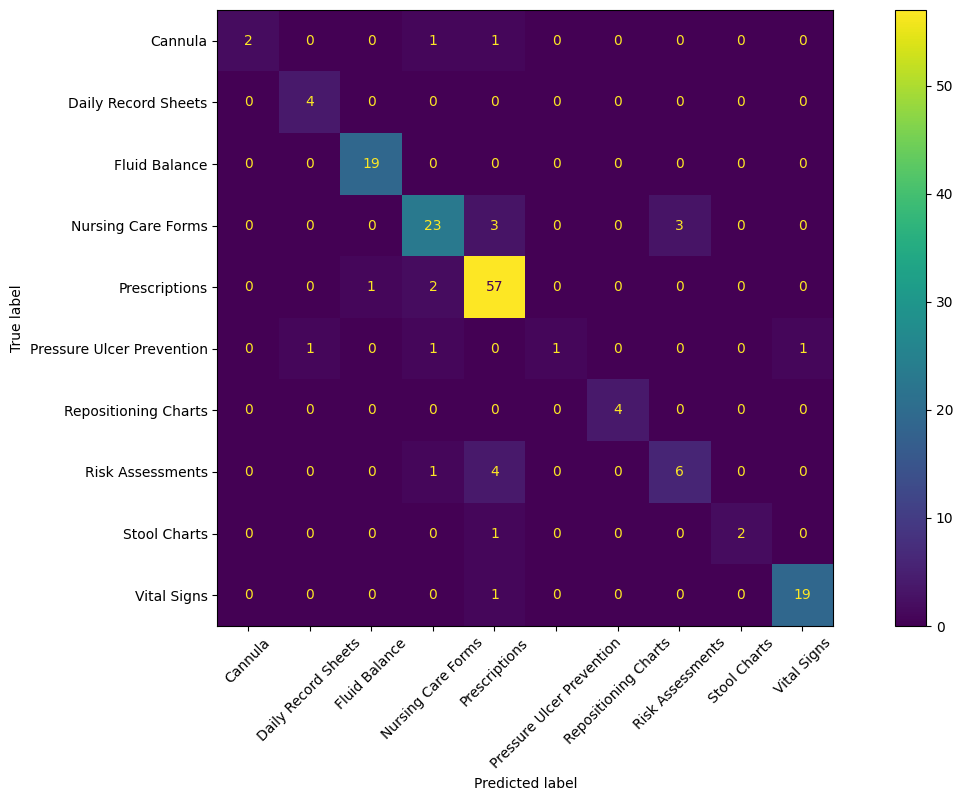

In [ ]:
cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=DOCUMENT_CLASSES
)

cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=90)
cm_display.figure_.set_size_inches(16, 8)

plt.show();

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
# Calculate precision
precision = precision_score(labels, predictions, average='weighted')
# Calculate recall
recall = recall_score(labels, predictions, average='weighted')
# Calculate F1 score
f1 = f1_score(labels, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.8670886075949367
Precision: 0.869933784963069
Recall: 0.8670886075949367
F1 score: 0.8582077166044809
